# Reverse time migration example on a 2D  acoustic model

## Set up environment.

In [1]:
from ipyparallel import Client
c = Client(profile='mpi')
dview = c[:]

with dview.sync_imports():
    import sys
    import numpy
    from examples.acoustic import demo_toolkit
    from examples.acoustic.Acoustic_codegen import Acoustic_cg

# Setup figure size
%matplotlib inline

import matplotlib.pyplot as plt
fig_size = [0, 0]
fig_size[0] = 18
fig_size[1] = 13
plt.rcParams["figure.figsize"] = fig_size

importing sys on engine(s)
importing numpy on engine(s)
importing demo_toolkit from examples.acoustic on engine(s)
importing Acoustic_cg from examples.acoustic.Acoustic_codegen on engine(s)


## Load synthetic velocity model.

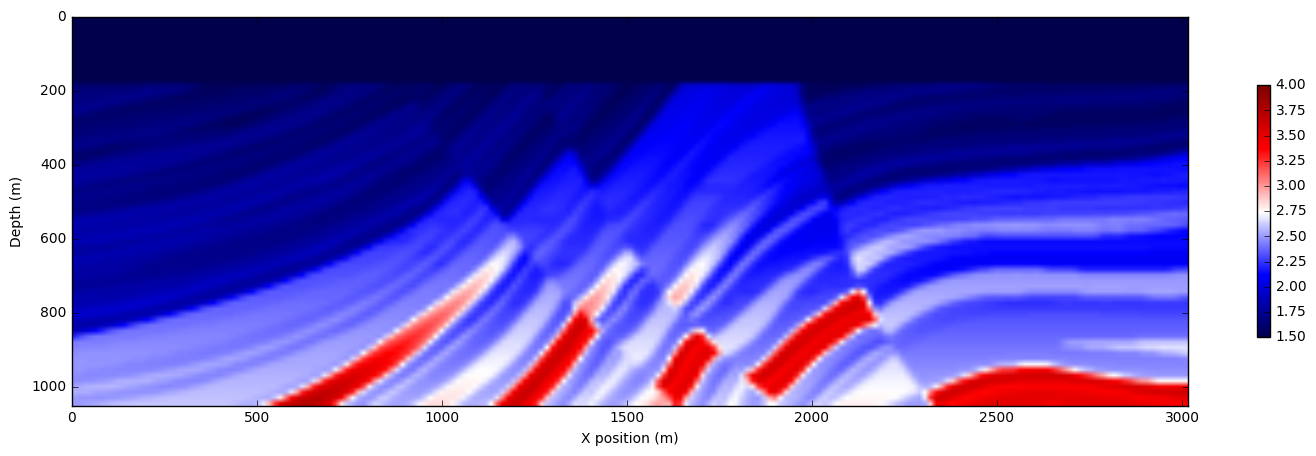

In [2]:
demo = demo_toolkit.small_marmousi2D()
model = demo.get_true_model()

demo.plot_velocity(model.vp)

## Create "initial guess" by smoothening the synthetic velocity model.

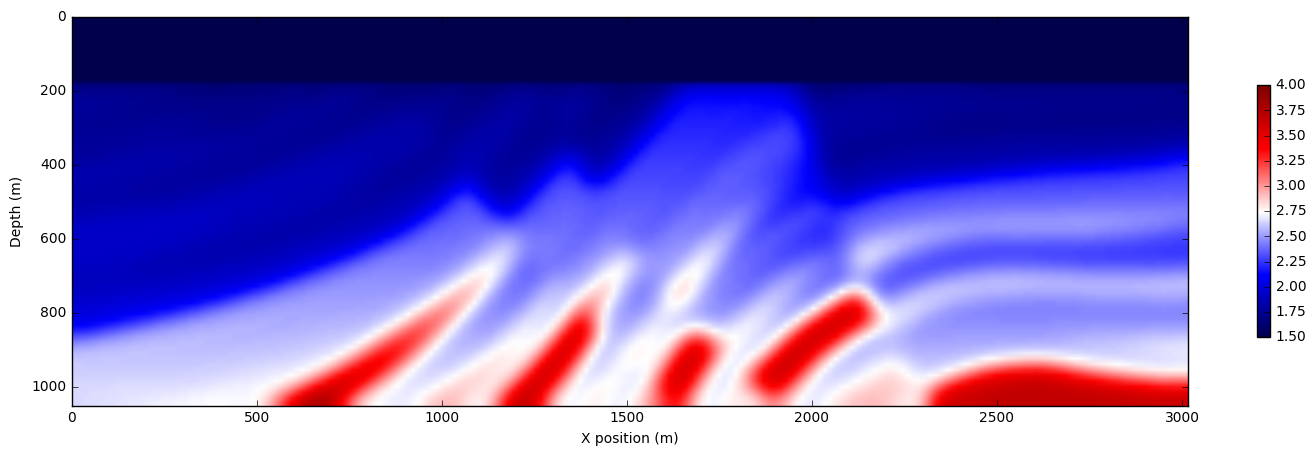

In [3]:
model0 = demo.get_initial_model()
demo.plot_velocity(model0.vp)

## Example of a shot record

In [4]:
# %load_ext snakeviz

/home/ggorman/projects/devito/examples/acoustic/demo_toolkit.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  location[0, 0] = self.sources[i]
Rewriter: 34 --> 28 flops (Gain: 1.21 X)
CustomCompiler: Compiling /tmp/devito-55029/09ebdd4e37aa784cca11216703c7f7b4dab9d79d.c
Shape: (281 x 150) - Cache Blocking: None
Time: 0.494552 s (51 MCells/s)
Stencil: 1.625000 OI, 1.46 GFlops/s (time: 0.492291 s)
Rewriter: 62 --> 47 flops (Gain: 1.32 X)
CustomCompiler: Compiling /tmp/devito-55029/abacb31a02cd904f19fdc7f6a9d08c8c0a4b2421.c
Shape: (281 x 150) - Cache Blocking: None
Time: 0.781533 s (28 MCells/s)
Stencil: 2.937500 OI, 1.67 GFlops/s (time: 0.779184 s)


2.69498825073
(656, 101)


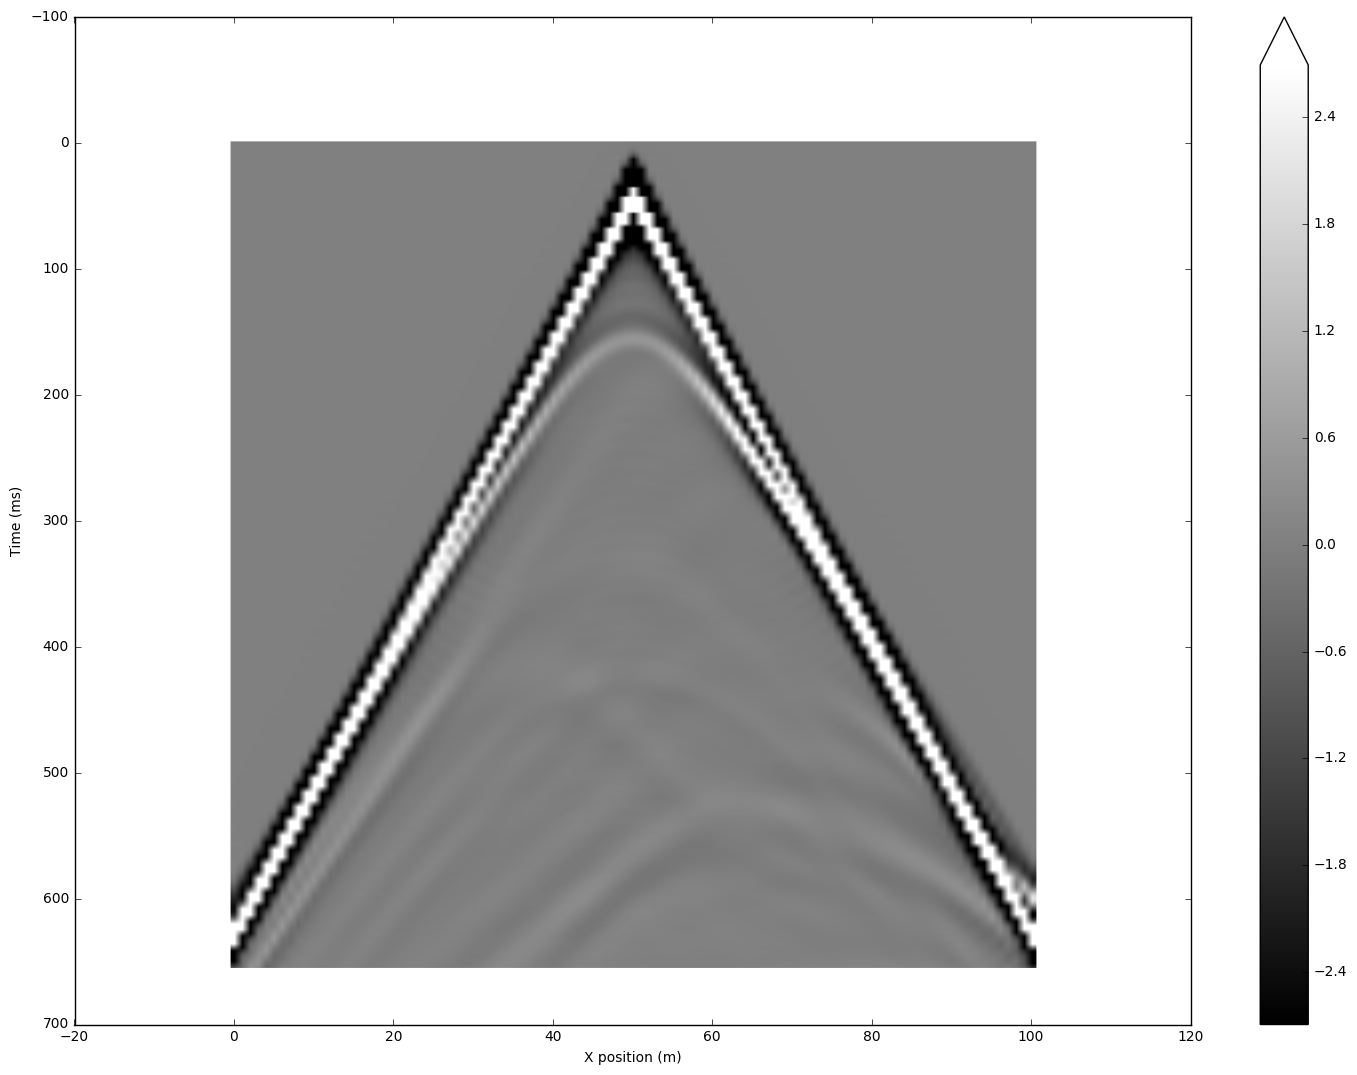

In [5]:
# %%snakeviz
data, rec, src = demo.get_shot(demo.nsrc/2)

# Create acoustic modelling kernel.
Acoustic = Acoustic_cg(model0, data, src, t_order=2, s_order=10)

# Execute acoustic forward model.
rec0, u, gflopss, oi, timings = Acoustic.Forward(save=False, dse='advanced')

demo.plot_record(rec0)

## RTM loop

# %%snakeviz
def grad_shot(i):
    demo = demo_toolkit.marmousi2D()

    model0 = demo.get_initial_model()
    data, rec, src = demo.get_shot(i)

    Acoustic0 = Acoustic_cg(model0, data, src, t_order=2, s_order=4)
    rec0, u0, gflopss, oi, timings = Acoustic0.Forward(save=True, dse='advanced')

    # Return gradient
    return Acoustic0.Gradient(rec0 - rec, u0, cache_blocking=None)

# grads = dview.map(grad_shot, range(8))
grads = map(grad_shot, range(8))

grad = sum(grads)

demo.plot_rtm(grad)
# print(grad)

## FWI

In [ ]:
import random
import scipy.optimize
import numpy.linalg
import os
os.environ["DEVITO_OPENMP"] = "1"

global fcalls, gcalls
fcalls = 0
gcalls = 0

def get_f_i(i):
    demo = demo_toolkit.small_marmousi2D()

    model0 = demo.get_initial_model()
    data, rec, src = demo.get_shot(i)

    Acoustic0 = Acoustic_cg(model0, data, src, t_order=2, s_order=4)
    rec0, u0, gflopss, oi, timings = Acoustic0.Forward(save=True, dse='advanced')

    # Calculate the functional, f
    residule = rec0 - rec
    f = 0.5*numpy.linalg.norm(residule)**2
    
    return f


def get_g_i(i):
    demo = demo_toolkit.small_marmousi2D()

    model0 = demo.get_initial_model()
    data, rec, src = demo.get_shot(i)

    Acoustic0 = Acoustic_cg(model0, data, src, t_order=2, s_order=4)
    rec0, u0, gflopss, oi, timings = Acoustic0.Forward(save=True, dse='advanced')

    # Calculate gradient, g
    residule = rec0 - rec    
    g = Acoustic0.Gradient(residule, u0, cache_blocking=None)

    return g[40:-40, 40:-40].flatten()

def get_fg(i):
    demo = demo_toolkit.small_marmousi2D()

    model0 = demo.get_initial_model()
    data, rec, src = demo.get_shot(i)

    Acoustic0 = Acoustic_cg(model0, data, src, t_order=2, s_order=4)
    rec0, u0, gflopss, oi, timings = Acoustic0.Forward(save=True, dse='advanced')

    residule = rec0 - rec
    f = 0.5*numpy.linalg.norm(residule)**2

    # Calculate gradient, g
    g = Acoustic0.Gradient(residule, u0, cache_blocking=None)

    return f, g[40:-40, 40:-40].flatten()

def get_f(vp, shots):
    global fcalls
    fcalls+=1
        
    f = sum(map(get_f_i, shots))

    return f

def get_g(vp, shots):
    global gcalls
    print ("gcalls = %i"%gcalls)
    gcalls+=1

    g = sum(map(get_g_i, shots))
    
    return g

def get_fg(vp, shots):
    global gcalls
    print ("gcalls = %i"%gcalls)
    print (shots)
    gcalls+=1

    f = 0
    g = None
    for fg in map(get_g_i, shots):
        f += fg[0]
        if g is None:
            g = numpy.copy(fg[1])
        else:
            g += fg[1]
    
    return f, g

shots = (random.sample(range(demo.nsrc), 4), )
result = scipy.optimize.minimize(get_f, model0.vp.flatten(), args=shots,
                                 method='BFGS', jac=get_g,
                                 options={"maxiter": 1, "maxfun":5, "disp": True})
#scipy.optimize.fmin_cg(get_f, model0.vp.flatten(), get_g, args=shots,
#                       maxiter=1, disp=True)

print ("True residule: %g"%(numpy.linalg.norm(model0.vp - model.vp)))

/home/ggorman/ipyparallel/lib/python3.5/site-packages/ipykernel/__main__.py:96: OptimizeWarning: Unknown solver options: maxfun


gcalls = 0


Rewriter: 34 --> 28 flops (Gain: 1.21 X)
CustomCompiler: Compiling /tmp/devito-55029/7f353225cb438360ba88aa75c0130369d04ec11e.c
Shape: (281 x 150) - Cache Blocking: None
Time: 0.494779 s (51 MCells/s)
Stencil: 1.625000 OI, 1.46 GFlops/s (time: 0.492306 s)
Rewriter: 34 --> 28 flops (Gain: 1.21 X)
CustomCompiler: Compiling /tmp/devito-55029/05d9ac06049d6933aff2a9d895087b575ab08209.c
Shape: (281 x 150) - Cache Blocking: None
Time: 0.464410 s (54 MCells/s)
Stencil: 1.625000 OI, 1.56 GFlops/s (time: 0.462090 s)
Rewriter: 42 --> 35 flops (Gain: 1.20 X)
CustomCompiler: Compiling /tmp/devito-55029/3b98d3d0f14fe8d441711d629b4ebb28134a1a62.c
Rewriter: 34 --> 28 flops (Gain: 1.21 X)
CustomCompiler: Compiling /tmp/devito-55029/76fdeb99729efa897534b45014132f7d2deb1bc9.c
Shape: (281 x 150) - Cache Blocking: None
Time: 0.508293 s (50 MCells/s)
Stencil: 1.625000 OI, 1.42 GFlops/s (time: 0.505959 s)
Rewriter: 34 --> 28 flops (Gain: 1.21 X)
CustomCompiler: Compiling /tmp/devito-55029/d1ecaa1bb3c00663101

gcalls = 1


Rewriter: 34 --> 28 flops (Gain: 1.21 X)
CustomCompiler: Compiling /tmp/devito-55029/47faf8e0a7ce578a547cb25abce140e19ba16264.c
Shape: (281 x 150) - Cache Blocking: None
Time: 0.490869 s (51 MCells/s)
Stencil: 1.625000 OI, 1.47 GFlops/s (time: 0.488637 s)
Rewriter: 34 --> 28 flops (Gain: 1.21 X)
CustomCompiler: Compiling /tmp/devito-55029/c98104785bf5566a13933d9c2adc6d64ad8ec373.c
Shape: (281 x 150) - Cache Blocking: None
Time: 0.447625 s (56 MCells/s)
Stencil: 1.625000 OI, 1.61 GFlops/s (time: 0.445463 s)
Rewriter: 42 --> 35 flops (Gain: 1.20 X)
CustomCompiler: Compiling /tmp/devito-55029/f75b08762dd2c1884a747f976354d12b0dc77268.c
Rewriter: 34 --> 28 flops (Gain: 1.21 X)
CustomCompiler: Compiling /tmp/devito-55029/e65167f76c123512355de9e2e440aa453f0a0572.c
Shape: (281 x 150) - Cache Blocking: None
Time: 0.516427 s (49 MCells/s)
Stencil: 1.625000 OI, 1.40 GFlops/s (time: 0.514060 s)
Rewriter: 34 --> 28 flops (Gain: 1.21 X)
CustomCompiler: Compiling /tmp/devito-55029/9e4d689ff4857bdd498

gcalls = 2


Rewriter: 34 --> 28 flops (Gain: 1.21 X)
CustomCompiler: Compiling /tmp/devito-55029/8b1ad5dc600ab7d354a22ead74e90594598e5619.c
Shape: (281 x 150) - Cache Blocking: None
Time: 0.498977 s (50 MCells/s)
Stencil: 1.625000 OI, 1.45 GFlops/s (time: 0.496547 s)
Rewriter: 34 --> 28 flops (Gain: 1.21 X)
CustomCompiler: Compiling /tmp/devito-55029/328e789446837698b345fef9d5aaf90cdb7f9d46.c
Shape: (281 x 150) - Cache Blocking: None
Time: 0.513694 s (49 MCells/s)
Stencil: 1.625000 OI, 1.41 GFlops/s (time: 0.511329 s)
Rewriter: 42 --> 35 flops (Gain: 1.20 X)
CustomCompiler: Compiling /tmp/devito-55029/01893d41adde1c1db177b67baeda55b7bdbb3549.c
Rewriter: 34 --> 28 flops (Gain: 1.21 X)
CustomCompiler: Compiling /tmp/devito-55029/50ce9207f59fb86b7ebd137e1476f9ede2063f53.c
Shape: (281 x 150) - Cache Blocking: None
Time: 0.522988 s (48 MCells/s)
Stencil: 1.625000 OI, 1.38 GFlops/s (time: 0.519863 s)
Rewriter: 34 --> 28 flops (Gain: 1.21 X)
CustomCompiler: Compiling /tmp/devito-55029/e2ad594672937285667

gcalls = 3


Rewriter: 34 --> 28 flops (Gain: 1.21 X)
CustomCompiler: Compiling /tmp/devito-55029/2c42588ec008a221f42af47863b994894cef7349.c
Shape: (281 x 150) - Cache Blocking: None
Time: 0.502383 s (50 MCells/s)
Stencil: 1.625000 OI, 1.44 GFlops/s (time: 0.500125 s)
Rewriter: 34 --> 28 flops (Gain: 1.21 X)
CustomCompiler: Compiling /tmp/devito-55029/8d78c11ca9a76ef39c6b51842c6b8b1506b30fd5.c
Shape: (281 x 150) - Cache Blocking: None
Time: 0.476016 s (53 MCells/s)
Stencil: 1.625000 OI, 1.52 GFlops/s (time: 0.473740 s)
Rewriter: 42 --> 35 flops (Gain: 1.20 X)
CustomCompiler: Compiling /tmp/devito-55029/5bc74942df1dcfb7c59834d37314fbf5514b8f50.c
Rewriter: 34 --> 28 flops (Gain: 1.21 X)
CustomCompiler: Compiling /tmp/devito-55029/9905869975138956e45cc765f9062256772b6814.c
Shape: (281 x 150) - Cache Blocking: None
Time: 0.514849 s (49 MCells/s)
Stencil: 1.625000 OI, 1.40 GFlops/s (time: 0.512527 s)
Rewriter: 34 --> 28 flops (Gain: 1.21 X)
CustomCompiler: Compiling /tmp/devito-55029/fb7638eea4c382c630d